In [1]:
import warnings
import os
import numpy as np
import xarray as xr
import seaborn as sns
from eofs.xarray import Eof
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec# Create 2x2 sub plots
from matplotlib import colorbar, colors
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

# Load Data

In [11]:
da_slp= xr.open_dataset('https://www.psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis2.derived/surface/mslp.mon.mean.nc')

In [12]:
#Convert datasets to hPa
da_slp['mslp'] = da_slp.mslp/100.0 #to hPa

**Calculate climatology and monthly anomalies**

In [14]:
#Climatology
da_clim = da_slp.groupby('time.month').mean(dim='time')
#Anomalies for MSLP
da_ano = da_slp.groupby('time.month') - da_clim

# **1. North Pacific Oscillation**

The North Pacific Oscillation (NPO) is defined as the second empirical orthogonal function (EOF) of sea level pressure (SLP) variability and  characterized by a north–south seesaw in boreal winter SLP over the North Pacific. It is a prominent mode of midlatitude wintertime atmospheric variability in the Pacific basin. It fluctuates between positive (high index) and negative (low index) phase. A low NPO index is associated with southerly airflow along the west coast of North America, which tends to bring warmer air into the region. A high NPO index brings a northerly airflow, with the corresponding movement into the region of colder, sub-polar air.

Learn more about NPO:[[1]](https://glossary.ametsoc.org/wiki/North_Pacific_Oscillation "What is NPO?") [[2]](https://climatedataguide.ucar.edu/climate-data/north-pacific-np-index-trenberth-and-hurrell-monthly-and-winter "NP Index?")

Let's compute NP Index using EOF on area weighted sea level pressure monthly anomalies over the region *20°N-60°N, 120°E-120°W*

## EOF Method

In [15]:
#Select Region
slp_reg = da_ano.mslp.sel(lon=slice(120,240), lat=slice(61,20))
slp_reg_runmean = (slp_reg.rolling(time=3, center=True).mean()).dropna(dim='time')
#weight
lats = np.array(slp_reg['lat'][:])
coslat = np.cos(np.deg2rad(lats)).clip(0., 1.)
wgts = np.sqrt(coslat)[..., np.newaxis]

#EOF
solver = Eof(slp_reg_runmean, weights=wgts)
eof_npi = solver.eofsAsCovariance(neofs=2)
pcs_npi = solver.pcs(npcs=2, pcscaling=1)
variance_fractions = solver.varianceFraction(neigs=1)
variance_fractions;

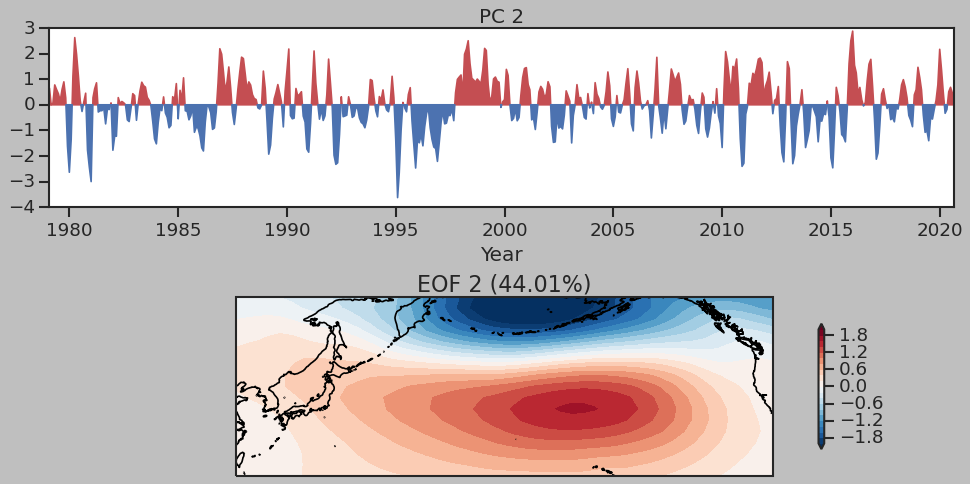

In [18]:
fig = plt.figure(figsize=(13,8))

sns.set(style="ticks", context="talk")
#plt.style.use("classic")
proj = ccrs.PlateCarree(central_longitude=180)
ax = fig.add_subplot(2,1,2, projection= proj)
clevs = np.arange(-2.0,2.2,0.2)

lons, lats = slp_reg.lon,  slp_reg.lat
ax.coastlines()
cs = ax.contourf(lons, lats, eof_npi.isel(mode=1).values,cmap=plt.cm.RdBu_r, transform=ccrs.PlateCarree(), levels=clevs, extend='both')
plt.title('EOF1 expressed as covariance', fontsize=16)

ax.set_title('EOF 2' + ' (' +  "{:05.2f}".format(variance_fractions.values[0]*100) +'%)', fontsize=20)
#cbar_ax = fig.add_axes([0.2, 0.10, 0.6, 0.02])
fig.colorbar(cs, shrink=0.7, orientation='vertical')

ax = fig.add_subplot(2, 1, 1)
ax.fill_between(slp_reg_runmean.time.values, 0, pcs_npi.isel(mode=1), where= pcs_npi.isel(mode=1)>0, facecolor='r', edgecolor='r',interpolate=True)
ax.fill_between(slp_reg_runmean.time.values, 0, pcs_npi.isel(mode=1), where= pcs_npi.isel(mode=1)<0, facecolor='b', edgecolor='b',interpolate=True);
ax.set_title('PC 2')
ax.set_xlabel('Year');

fig.subplots_adjust(bottom=0.2, top=0.9, left=0.08, right=0.95, wspace=0.05, hspace=0.5);


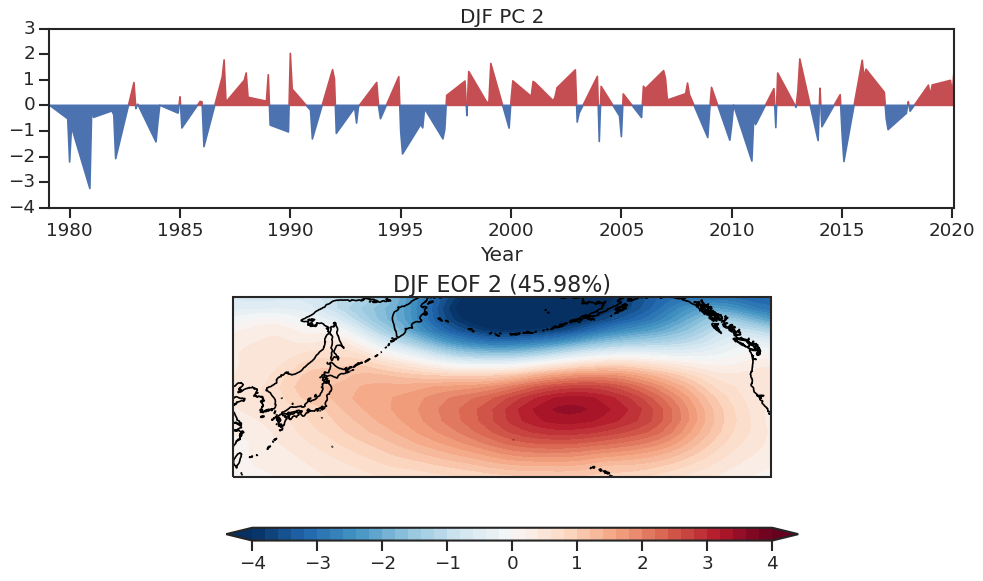

In [19]:
#EOF for DJF
da_ano_djf = da_ano.sel(time=(da_ano['time.season'] == 'DJF'))
da_ano_djf = da_ano_djf.sel(time=slice(da_ano_djf.time[1], None))

#da_ano_djf2 = da_ano_djf.mslp.resample(time='QS-Dec').mean()[0::4]


slp_reg_djf = da_ano_djf.mslp.sel(lon=slice(120,240), lat=slice(61,20))
solver = Eof(slp_reg_djf,weights=wgts)
eof_npi_djf = solver.eofsAsCovariance(neofs=2)
pcs_npi_djf = solver.pcs(npcs=2, pcscaling=1)
variance_fractions = solver.varianceFraction(neigs=1)
variance_fractions;

fig = plt.figure(figsize=(13,8))

sns.set(style="ticks", context="talk")
#plt.style.use("classic")
ax = fig.add_subplot(2,1,2, projection = ccrs.PlateCarree(180))
clevs = np.arange(-4.0,4.2,0.2)

lons, lats = slp_reg_djf.lon,  slp_reg_djf.lat
ax.coastlines()
#ax.set_global()
#ax.add_feature(cfeature.LAND, color='k')
cs = ax.contourf(lons, lats,-1* eof_npi_djf.isel(mode=1).values,cmap=plt.cm.RdBu_r, transform=ccrs.PlateCarree(), levels=clevs, extend='both')
plt.title('EOF1 expressed as covariance', fontsize=16)

ax.set_title('DJF EOF 2' + ' (' +  "{:05.2f}".format(variance_fractions.values[0]*100) +'%)', fontsize=20)
cbar_ax = fig.add_axes([0.25, 0.10, 0.55, 0.02])
fig.colorbar(cs,cax=cbar_ax, shrink=0.5, orientation='horizontal')

pcs_npi_djf = -1*pcs_npi_djf;
ax = fig.add_subplot(2, 1, 1)
ax.fill_between(slp_reg_djf.time.values, 0, pcs_npi_djf.isel(mode=1), where= pcs_npi_djf.isel(mode=1)>0, facecolor='r', edgecolor='r',interpolate=True)
ax.fill_between(slp_reg_djf.time.values, 0, pcs_npi_djf.isel(mode=1), where= pcs_npi_djf.isel(mode=1)<0, facecolor='b', edgecolor='b',interpolate=True);
ax.set_title('DJF PC 2')
ax.set_xlabel('Year');

fig.subplots_adjust(bottom=0.2, top=0.9, left=0.08, right=0.95, wspace=0.05, hspace=0.5);


# 2. North Atlantic Osillation

The North Atkantic Oscillation (NAO) is defined simply as the variations in the large-scale surface pressure gradient in the North Atlantic region. In the average state of the atmosphere, the North Atlantic surface pressure is relatively high in the subtropics at latitudes 20°N to 40°N ('the Azores High'), and lower further North at latitudes 50°N to 70°N (the 'Icelandic Low'). The North-South pressure difference determines the strength of the westerly winds across the Atlantic and is known as the North Atlantic Oscillation (NAO).

When the pressure difference is large, the NAO is positive and the westerly winds are strong and storms tend to be stronger, more frequent and travel across northwestern Europe. When the pressure difference is small, they travel across southern Europe. The NAO is also associated with changes in temperature and rainfall in Europe and North America.

Learn more about NPO:
[[1]](https://www.metoffice.gov.uk/research/climate/seasonal-to-decadal/gpc-outlooks/ens-mean/nao-description "What is NAO?") 
[[2]](https://climate.ncsu.edu/climate/patterns/nao "What is NAO?")
[[3]](https://climatedataguide.ucar.edu/climate-data/hurrell-north-atlantic-oscillation-nao-index-station-based "NP Index?")

Let's compute NAO Index using EOF on area weighted DJF sea level pressure monthly anomalies over the region *20°N-80°N, 90°W-40E°E*

In [20]:
#Atlantic Centered
da_ano_atl = da_ano.copy()
da_ano_atl['lon'] =xr.where(da_ano_atl.lon<180, da_ano_atl.lon, -360+da_ano_atl.lon).sortby('lon')
da_ano_atl = da_ano_atl.roll(lon=72);

<ipython-input-20-f786760145cd>:4: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  da_ano_atl = da_ano_atl.roll(lon=72);


In [21]:
#DJF computation
da_ano_djf_atl = da_ano_atl.sel(time=(da_ano['time.season'] == 'DJF'))

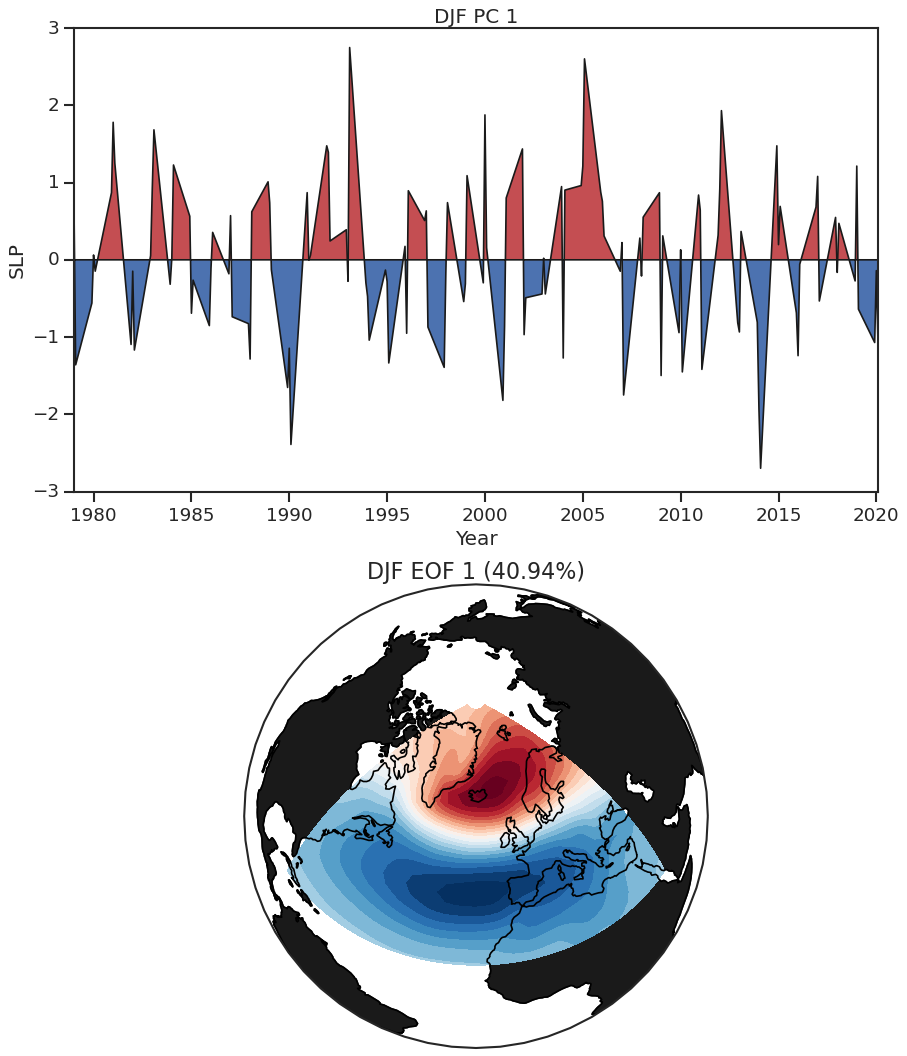

In [22]:
#EOF for DJF
slp_reg_djf = da_ano_djf_atl.mslp.sel(lon=slice(-80,40), lat=slice(90,20))

lats = np.array(slp_reg_djf['lat'][:])
coslat = np.cos(np.deg2rad(lats)).clip(0., 1.)
wgts = np.sqrt(coslat)[..., np.newaxis]

solver = Eof(slp_reg_djf,weights=wgts)
eof_nao_djf = solver.eofsAsCovariance(neofs=2)
pcs_nao_djf = solver.pcs(npcs=2, pcscaling=1)
variance_fractions = solver.varianceFraction(neigs=1)
variance_fractions;

gs = gridspec.GridSpec(2, 1)
fig = plt.figure(figsize=(15,15))

sns.set(style="ticks", context="talk")
proj = ccrs.Orthographic(central_longitude=-20, central_latitude=60)
ax = fig.add_subplot(2,1,2, projection = proj)
clevs = np.arange(-6.0,7,1)

lons, lats = slp_reg_djf.lon,  slp_reg_djf.lat
ax.coastlines()
ax.set_global()
ax.add_feature(cfeature.LAND, color='k')
cs = ax.contourf(lons, lats, -1*eof_nao_djf.isel(mode=0).values,cmap=plt.cm.RdBu_r, transform=ccrs.PlateCarree(), levels=21 , extend='both')
plt.title('EOF1 expressed as covariance', fontsize=16)

ax.set_title('DJF EOF 1' + ' (' +  "{:05.2f}".format(variance_fractions.values[0]*100) +'%)', fontsize=20)
#cbar_ax = fig.add_axes([0.25, 0.10, 0.55, 0.02])

pcs_npi_djf = -1*pcs_npi_djf;
ax = fig.add_subplot(2, 1, 1)
ax.fill_between(slp_reg_djf.time.values, 0, pcs_nao_djf.isel(mode=1), where= pcs_nao_djf.isel(mode=1)>0, facecolor='r', edgecolor='k',interpolate=True)
ax.fill_between(slp_reg_djf.time.values, 0, pcs_nao_djf.isel(mode=1), where= pcs_nao_djf.isel(mode=1)<0, facecolor='b', edgecolor='k',interpolate=True);
ax.set_title('DJF PC 1')
ax.set_ylabel('SLP')
ax.set_xlabel('Year');

fig.subplots_adjust(bottom=0.05, top=0.9, left=0.28, right=0.95, wspace=0.05, hspace=0.2);
